In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install seaborn
RANDOM_SEED = 42

# 各パス指定

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [25]:
NUM_CLASSES = 5

# 学習データ読み込み

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [31]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


InvalidArgumentError:  Received a label value of 5 which is outside the valid range of [0, 5).  Label values: 1 1 0 1 0 1 3 1 0 2 1 3 1 1 3 5 2 2 1 3 2 2 1 2 2 2 0 3 1 0 4 3 2 0 2 1 1 2 1 1 0 1 3 2 1 1 1 2 2 0 0 3 2 3 1 1 0 2 2 2 5 0 0 2 2 2 0 2 0 5 2 0 2 3 1 2 1 0 2 1 4 1 2 1 3 4 0 0 0 0 2 1 1 2 1 0 1 1 2 1 1 2 0 0 1 2 1 1 0 2 0 0 4 0 0 1 2 1 1 1 1 1 1 0 1 1 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-33-97b42b06cced>:7) ]] [Op:__inference_train_function_2011]

Function call stack:
train_function


In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 774us/step - loss: 0.1965 - accuracy: 0.9760


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[9.8197615e-01 1.5942389e-02 2.0763052e-03 5.1634870e-06 1.6380014e-08]
0


# 混同行列

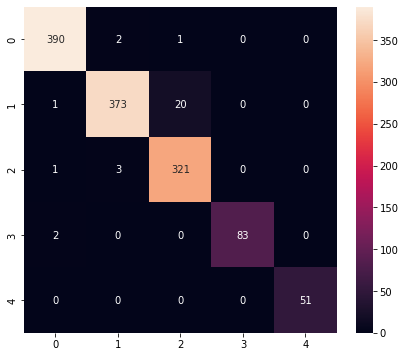

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       393
           1       0.99      0.95      0.97       394
           2       0.94      0.99      0.96       325
           3       1.00      0.98      0.99        85
           4       1.00      1.00      1.00        51

    accuracy                           0.98      1248
   macro avg       0.98      0.98      0.98      1248
weighted avg       0.98      0.98      0.98      1248



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\2021TI~1\AppData\Local\Temp\tmp07oaqigh\assets


6400

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.8197615e-01 1.5942389e-02 2.0763061e-03 5.1634870e-06 1.6380012e-08]
0
